# Present the numerial results

This notebook focuses on reading the metrics from the output files 
and presenting them.

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import libraries

In [4]:
import os
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Literal, Tuple, Dict, Any, Optional
from PIL import Image
from tqdm.notebook import tqdm
from pathlib import Path

from sithom.plot import (
    plot_defaults,
    label_subplots,
    get_dim,
    set_dim,
    PALETTE,
    STD_CLR_LIST,
    CAM_BLUE,
    BRICK_RED,
    OX_BLUE,
)

# # Use Latex (optional)
# uses_latex = True
uses_latex = False
plot_defaults(use_tex=uses_latex)

# # ---- example set of graphs ---

# import numpy as np
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(2, 2)

# x = np.linspace(0, np.pi, num=100)
# axs[0, 0].plot(x, np.sin(x), color=STD_CLR_LIST[0])
# axs[0, 1].plot(x, np.cos(x), color=STD_CLR_LIST[1])
# axs[1, 0].plot(x, np.sinc(x), color=STD_CLR_LIST[2])
# axs[1, 1].plot(x, np.abs(x), color=STD_CLR_LIST[3])

# # set size
# set_dim(fig, fraction_of_line_width=1, ratio=(5 ** 0.5 - 1) / 2)

# # label subplots

# label_subplots(axs.T,  labels=["i"*x for x in range(1,5)], start_from=0, fontsize=10, x_pos=-0.1, y_pos=1.2)

In [9]:
from utils.makepath import makepath as mkp
from data.mri.mri_data import DataUtil

## Locate project root directory

First, make sure we know the relative path to the root of the project.

In [7]:
# Root directory of the project is two levels up from this notebook.
# Change this if the notebook is moved.
num_levels_up = 2

root_dir = mkp(".")
for _ in range(num_levels_up):
    root_dir = mkp(root_dir, "..")  # go up one level

os.listdir(root_dir)    # We should see the project root directory

['scripts',
 'requirements.txt',
 'mri.egg-info',
 'venv',
 'README.md',
 'figures',
 'config',
 'LICENSE',
 'utils',
 'networks',
 'tmp',
 'dyn_mri_test.py',
 '.gitignore',
 'gradops',
 'pyproject.toml',
 'gifs',
 'data',
 'pdhg',
 'data_lib',
 'wandb',
 'encoding_objects',
 '.git']

In [10]:
default_device = "cpu"
# default_device = "cuda"

TypeError: DataUtil.__init__() missing 1 required positional argument: 'config'

## Config

In [6]:
T = 256
# dataset_name = "turtleid"
dataset_name = "standard50"
data_path = mkp(root_dir, "data", dataset_name)
action = "test"
sigmas = [0.05, 0.1, 0.15, 0.2]
# If 0, all samples are used.
# Will be multiplied by the number of sigma values to get the total number of samples per epoch.
# num_samples = 1
num_samples = 50
first_sample_index = 0


def get_common_config():
    return {
        "device": default_device,
        "data" : {
            "dataset": dataset_name,
            "data_path": data_path,
            "generated_data_path": mkp(data_path, "generated"),

            f"{action}_num_samples": num_samples,
            f"{action}_first_sample_index": first_sample_index,
            "resize_square": 512,
            "sigmas" : str(sigmas),

            "loading_method": "test_mat",
        },

        "pdhg" : {
            "T": T,
        },

        "results" : {
            "action": action,
        },
    }

## Read the output files

### Utility functions

In [7]:
metrics_obj = Metrics()

def get_df_all_results(npy_dataset):
    df_all_results = pd.DataFrame()
    for np_arr, clean_np in npy_dataset:
        df_results = metrics_obj.compute_np(np_arr, clean_np)
        df_all_results = pd.concat([df_all_results, df_results])
    return df_all_results

def get_df(config, loads_precomputed=False, saves_results=False):
    results_obj = Results(
        config=config,
        dataset_constructor_class=TurtleDatasetConstructor,
        tqdm=tqdm,
    )

    if loads_precomputed:
        df = results_obj.load_metrics_csv()
    else:
        df = results_obj.generate_metrics_results_dataframe(saves_results=saves_results)

    return df

def merge_dicts(a, b):
    c = {}
    for key in a:
        c[key] = a[key]
    for key in b:
        if key in a:
            c[key] = {**a[key], **b[key]}
        else:
            c[key] = b[key]
    return c

def print_mean_and_std(df):
    psnr_mean = df["PSNR"].mean()
    psnr_std = df["PSNR"].std()
    ssim_mean = df["SSIM"].mean()
    ssim_std = df["SSIM"].std()
    # print(f"{psnr_mean:.2f} ± {psnr_std:.2f} \t {ssim_mean:.4f} ± {ssim_std:.3f}", end="\t")
    print(f"{psnr_mean:.2f} ± {psnr_std:.2f} \t {ssim_mean:.4f} ± {ssim_std:.3f}")

def print_mean_and_std_by_sigma(df):
    print(sigmas)
    for sigma in sigmas:
        df_sigma = df[df["sigma"] == sigma]
        print_mean_and_std(df_sigma)
    print_mean_and_std(df)  # all sigmas

In [8]:
def get_results(
        dataset: Literal["turtleid", "standard50"],
        model_name: Literal["u_tv", "u_tgv_type_1", "u_tgv_type_2"],
        results_dir = mkp(root_dir, "results"),
):
    results_csv = mkp(results_dir, f"{model_name}_results_{dataset}.csv")
    results_df = pd.read_csv(results_csv)
    return results_df

## Compare by dataset

### Four examples

##### U-TV

In [9]:
u_tv_examples_df = get_results(dataset="examples", model_name="u_tv")
u_tv_examples_df.head()

,Unnamed: 0,mat_file_name,sigma,MSE,PSNR,SSIM
0,0,../../data/examples/greyscale_256/cameraman,0.05,0.000723,31.407604,0.889027
1,1,../../data/examples/greyscale_256/parrot,0.05,0.000401,33.965744,0.920537
2,2,../../data/examples/greyscale_256/orestis,0.05,0.000410,33.876552,0.908583
3,3,../../data/examples/greyscale_256/hatchling,0.05,0.000582,32.347156,0.906070
4,4,../../data/examples/greyscale_256/cameraman,0.10,0.001410,28.506677,0.839941


In [10]:
print(u_tv_examples_df["mat_file_name"].unique())

['../../data/examples/greyscale_256/cameraman'
 '../../data/examples/greyscale_256/parrot'
 '../../data/examples/greyscale_256/orestis'
 '../../data/examples/greyscale_256/hatchling']


In [11]:
def print_examples(df: pd.DataFrame) -> None:
    for sigma in [0.05, 0.1, 0.15, 0.2]:
        df_sigma = df[df["sigma"] == sigma]
        print(f"sigma = {sigma}")
        print(df_sigma[["PSNR", "SSIM"]])
        print()

In [12]:
print_examples(u_tv_examples_df)

sigma = 0.05
        PSNR      SSIM
0  31.407604  0.889027
1  33.965744  0.920537
2  33.876552  0.908583
3  32.347156  0.906070

sigma = 0.1
        PSNR      SSIM
4  28.506677  0.839941
5  30.874601  0.880224
6  30.589943  0.850938
7  28.675792  0.823014

sigma = 0.15
         PSNR      SSIM
8   26.072773  0.775618
9   28.465734  0.847865
10  28.680602  0.818394
11  26.583166  0.745418

sigma = 0.2
         PSNR      SSIM
12  24.573627  0.739775
13  26.858620  0.823327
14  27.052586  0.788044
15  25.330899  0.690937



##### U-TGV type-1

In [13]:
u_tgv_type_1_examples_df = get_results(dataset="examples", model_name="u_tgv_type_1")
u_tgv_type_1_examples_df.head()

,Unnamed: 0,mat_file_name,sigma,MSE,PSNR,SSIM
0,0,../../data/examples/greyscale_256/cameraman,0.05,0.000716,31.451323,0.888464
1,1,../../data/examples/greyscale_256/parrot,0.05,0.000408,33.897069,0.920185
2,2,../../data/examples/greyscale_256/orestis,0.05,0.000416,33.807516,0.908947
3,3,../../data/examples/greyscale_256/hatchling,0.05,0.000568,32.454157,0.910185
4,4,../../data/examples/greyscale_256/cameraman,0.10,0.001406,28.521136,0.836887


In [14]:
u_tgv_type_1_examples_df["mat_file_name"].unique()

array(['../../data/examples/greyscale_256/cameraman',
       '../../data/examples/greyscale_256/parrot',
       '../../data/examples/greyscale_256/orestis',
       '../../data/examples/greyscale_256/hatchling'], dtype=object)

In [15]:
print_examples(u_tgv_type_1_examples_df)

sigma = 0.05
        PSNR      SSIM
0  31.451323  0.888464
1  33.897069  0.920185
2  33.807516  0.908947
3  32.454157  0.910185

sigma = 0.1
        PSNR      SSIM
4  28.521136  0.836887
5  30.854972  0.882732
6  30.548996  0.853846
7  28.783710  0.831616

sigma = 0.15
         PSNR      SSIM
8   26.051340  0.773595
9   28.494022  0.849940
10  28.602682  0.819308
11  26.664165  0.754778

sigma = 0.2
         PSNR      SSIM
12  24.524545  0.735380
13  26.804303  0.821270
14  26.994277  0.787389
15  25.347850  0.695135



##### U-TGV type-2

In [16]:
u_tgv_type_2_examples_df = get_results(dataset="examples", model_name="u_tgv_type_2")
u_tgv_type_2_examples_df.head()

,Unnamed: 0,mat_file_name,sigma,MSE,PSNR,SSIM
0,0,../../data/examples/greyscale_256/cameraman,0.05,0.000692,31.601515,0.892459
1,1,../../data/examples/greyscale_256/parrot,0.05,0.000383,34.164572,0.923900
2,2,../../data/examples/greyscale_256/orestis,0.05,0.000404,33.933980,0.912234
3,3,../../data/examples/greyscale_256/hatchling,0.05,0.000537,32.703378,0.916253
4,4,../../data/examples/greyscale_256/cameraman,0.10,0.001373,28.624303,0.840889


In [17]:
u_tgv_type_2_examples_df["mat_file_name"].unique()

array(['../../data/examples/greyscale_256/cameraman',
       '../../data/examples/greyscale_256/parrot',
       '../../data/examples/greyscale_256/orestis',
       '../../data/examples/greyscale_256/hatchling'], dtype=object)

In [18]:
print_examples(u_tgv_type_2_examples_df)

sigma = 0.05
        PSNR      SSIM
0  31.601515  0.892459
1  34.164572  0.923900
2  33.933980  0.912234
3  32.703378  0.916253

sigma = 0.1
        PSNR      SSIM
4  28.624303  0.840889
5  31.025984  0.888304
6  30.755578  0.860041
7  29.016131  0.842008

sigma = 0.15
         PSNR      SSIM
8   26.185746  0.778819
9   28.766414  0.858883
10  28.788419  0.825310
11  26.887364  0.770587

sigma = 0.2
         PSNR      SSIM
12  24.669621  0.742807
13  27.079167  0.832739
14  27.181850  0.793840
15  25.531866  0.714181



### TurtleID50

In [19]:
u_tv_turtleid_df = get_results(dataset="turtleid", model_name="u_tv")
u_tv_turtleid_df.head()

,Unnamed: 0,mat_file_name,sigma,MSE,PSNR,SSIM
0,0,../../data/turtleid/greyscale_512/t085/RKYeghQ...,0.05,0.000176,37.536519,0.940888
1,1,../../data/turtleid/greyscale_512/t004/KooRzgw...,0.05,0.000317,34.987786,0.916212
2,2,../../data/turtleid/greyscale_512/t136/ztMVXcE...,0.05,0.000277,35.582378,0.915904
3,3,../../data/turtleid/greyscale_512/t224/yTBwrhf...,0.05,0.000517,32.862549,0.843687
4,4,../../data/turtleid/greyscale_512/t333/RcPWUfN...,0.05,0.000149,38.255320,0.935452


In [20]:
print_mean_and_std_by_sigma(u_tv_turtleid_df)

[0.05, 0.1, 0.15, 0.2]
36.55 ± 2.47 	 0.9199 ± 0.027
33.86 ± 2.69 	 0.8743 ± 0.048
32.44 ± 2.77 	 0.8458 ± 0.061
31.46 ± 2.78 	 0.8259 ± 0.071
33.58 ± 3.28 	 0.8665 ± 0.064


In [21]:
u_tgv_type_1_turtleid_df = get_results(dataset="turtleid", model_name="u_tgv_type_1")
u_tgv_type_1_turtleid_df.head()

,Unnamed: 0,mat_file_name,sigma,MSE,PSNR,SSIM
0,0,../../data/turtleid/greyscale_512/t085/RKYeghQ...,0.05,0.000185,37.324133,0.940008
1,1,../../data/turtleid/greyscale_512/t004/KooRzgw...,0.05,0.000328,34.834696,0.915038
2,2,../../data/turtleid/greyscale_512/t136/ztMVXcE...,0.05,0.000283,35.486854,0.914762
3,3,../../data/turtleid/greyscale_512/t224/yTBwrhf...,0.05,0.000526,32.788043,0.840576
4,4,../../data/turtleid/greyscale_512/t333/RcPWUfN...,0.05,0.000153,38.157680,0.934629


In [22]:
print_mean_and_std_by_sigma(u_tgv_type_1_turtleid_df)

[0.05, 0.1, 0.15, 0.2]
36.38 ± 2.42 	 0.9177 ± 0.028
33.61 ± 2.49 	 0.8706 ± 0.048
32.04 ± 2.39 	 0.8395 ± 0.061
30.91 ± 2.26 	 0.8151 ± 0.069
33.23 ± 3.14 	 0.8607 ± 0.066


In [23]:
u_tgv_type_2_turtleid_df = get_results(dataset="turtleid", model_name="u_tgv_type_2")
u_tgv_type_2_turtleid_df.head()

,Unnamed: 0,mat_file_name,sigma,MSE,PSNR,SSIM
0,0,../../data/turtleid/greyscale_512/t085/RKYeghQ...,0.05,0.000178,37.501370,0.942163
1,1,../../data/turtleid/greyscale_512/t004/KooRzgw...,0.05,0.000310,35.085843,0.919692
2,2,../../data/turtleid/greyscale_512/t136/ztMVXcE...,0.05,0.000261,35.825443,0.921485
3,3,../../data/turtleid/greyscale_512/t224/yTBwrhf...,0.05,0.000502,32.996243,0.850172
4,4,../../data/turtleid/greyscale_512/t333/RcPWUfN...,0.05,0.000140,38.530363,0.940124


In [24]:
print_mean_and_std_by_sigma(u_tgv_type_2_turtleid_df)

[0.05, 0.1, 0.15, 0.2]
36.64 ± 2.43 	 0.9228 ± 0.026
33.79 ± 2.45 	 0.8768 ± 0.047
32.16 ± 2.34 	 0.8461 ± 0.060
31.01 ± 2.22 	 0.8228 ± 0.069
33.40 ± 3.16 	 0.8671 ± 0.065


### Create a difference histogram

U-TGV type-2 vs U-TV, TurtleID dataset


  0%|          | 0/4 [00:00<?, ?it/s]

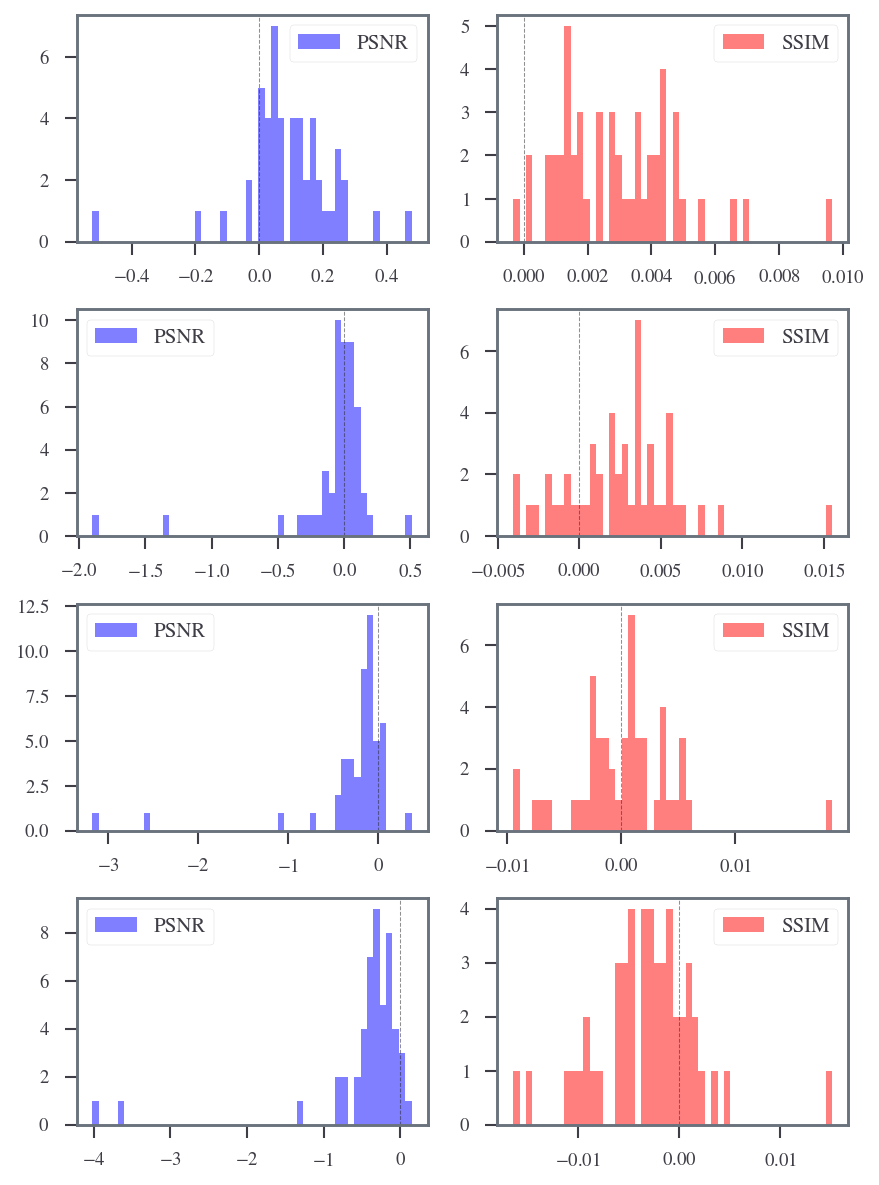

In [25]:
def visualize_hist(sigmas, df_A, df_B, ratio):

    psnr_diffs = {}
    ssim_diffs = {}
    sigmas = [0.05, 0.1, 0.15, 0.2]
    for sigma in sigmas:
        df_A_sigma = df_A[df_A["sigma"] == sigma]
        df_B_sigma = df_B[df_B["sigma"] == sigma]

        psnr_diffs[sigma] = df_A_sigma["PSNR"] - df_B_sigma["PSNR"]
        ssim_diffs[sigma] = df_A_sigma["SSIM"] - df_B_sigma["SSIM"]

    fig, axs = plt.subplots(len(sigmas), 2)

    if uses_latex:
        # set size
        set_dim(
            fig,
            fraction_of_line_width=1,
            ratio=ratio
        )
        # label subplots
        label_subplots(
            axs,
            # start_from=0,
            # fontcolor="red",
            fontsize=10
        )
    else:
        fig.set_size_inches(6, len(sigmas) * ratio)

    for i_sigma in tqdm(range(len(sigmas)), leave=False):
        sigma = sigmas[i_sigma]

        n_bins = 50

        plt.subplot(len(sigmas), 2, i_sigma * 2 + 1)
        plt.hist(
            psnr_diffs[sigma], bins=n_bins,
            color=STD_CLR_LIST[0] if uses_latex else 'blue',
            alpha=0.5, label="PSNR",
            # range=(-abs_psnr, abs_psnr)
        )
        # Draw a vertical line at 0
        plt.axvline(x=0, color='k',
                    linestyle='--',
                    alpha=0.5,
                    linewidth=0.5)
        # plt.title(f"PSNR difference, SD = {sigma}",
        #           fontdict={"fontsize": 6},
        #           position=(0.5, 0.5))
        plt.legend()

        plt.subplot(len(sigmas), 2, i_sigma * 2 + 2)
        plt.hist(
            ssim_diffs[sigma], bins=n_bins,
            color=STD_CLR_LIST[1] if uses_latex else 'red',
            alpha=0.5, label="SSIM",
            # range=(-abs_ssim, abs_ssim)
        )
        # Draw a vertical line at 0
        plt.axvline(x=0, color='k',
                    linestyle='--',
                    alpha=0.5,
                    linewidth=0.5)
        # plt.title(f"SSIM difference, SD = {sigma}",
        #             fontdict={"fontsize": 6},
        #           position=(0.5, 0.5))

        # plt.suptitle(f"PSNR and SSIM differences for sigma = {sigma}, T = {T}")
        sigma_str = str(sigma).replace(".", "_")
        plt.legend()

        # plt.savefig(f"../../data/test_cases/CCIA_dataset/histograms_T_{T}_sigma_{sigma_str}.png")
        # plt.show()


print("U-TGV type-2 vs U-TV, TurtleID dataset")
visualize_hist(
    [0.05, 0.1, 0.15, 0.2],
    df_A = u_tgv_type_2_turtleid_df,
    df_B = u_tv_turtleid_df,
    ratio=2)
plt.show()

### Standard50

In [26]:
u_tv_standard50_df = get_results(dataset="standard50", model_name="u_tv")
u_tv_standard50_df.head()

,Unnamed: 0,mat_file_name,sigma,MSE,PSNR,SSIM
0,0,../../data/standard50/greyscale_512/1.png,0.05,0.001298,28.866131,0.869918
1,1,../../data/standard50/greyscale_512/2.png,0.05,0.000616,32.102601,0.844636
2,2,../../data/standard50/greyscale_512/3.png,0.05,0.000549,32.601322,0.879784
3,3,../../data/standard50/greyscale_512/4.png,0.05,0.000587,32.310623,0.852984
4,4,../../data/standard50/greyscale_512/5.png,0.05,0.000530,32.760746,0.875616


In [27]:
print_mean_and_std_by_sigma(u_tv_standard50_df)

[0.05, 0.1, 0.15, 0.2]
30.86 ± 2.70 	 0.8567 ± 0.051
27.96 ± 2.67 	 0.7746 ± 0.068
26.41 ± 2.67 	 0.7135 ± 0.085
25.38 ± 2.65 	 0.6686 ± 0.098
27.65 ± 3.37 	 0.7534 ± 0.105


In [28]:
u_tgv_type_1_standard50_df = get_results(dataset="standard50", model_name="u_tgv_type_1")
u_tgv_type_1_standard50_df.head()

,Unnamed: 0,mat_file_name,sigma,MSE,PSNR,SSIM
0,0,../../data/standard50/greyscale_512/1.png,0.05,0.001779,27.497765,0.841585
1,1,../../data/standard50/greyscale_512/2.png,0.05,0.000641,31.933000,0.839749
2,2,../../data/standard50/greyscale_512/3.png,0.05,0.000569,32.450809,0.874889
3,3,../../data/standard50/greyscale_512/4.png,0.05,0.000607,32.170815,0.847830
4,4,../../data/standard50/greyscale_512/5.png,0.05,0.000524,32.809567,0.876530


In [29]:
print_mean_and_std_by_sigma(u_tgv_type_1_standard50_df)

[0.05, 0.1, 0.15, 0.2]
30.75 ± 2.64 	 0.8528 ± 0.052
27.89 ± 2.60 	 0.7695 ± 0.070
26.33 ± 2.58 	 0.7079 ± 0.086
25.25 ± 2.55 	 0.6595 ± 0.098
27.56 ± 3.31 	 0.7474 ± 0.106


In [30]:
u_tgv_type_2_standard50_df = get_results(dataset="standard50", model_name="u_tgv_type_2")
u_tgv_type_2_standard50_df.head()

,Unnamed: 0,mat_file_name,sigma,MSE,PSNR,SSIM
0,0,../../data/standard50/greyscale_512/1.png,0.05,0.001250,29.029291,0.873901
1,1,../../data/standard50/greyscale_512/2.png,0.05,0.000616,32.100715,0.846062
2,2,../../data/standard50/greyscale_512/3.png,0.05,0.000544,32.641548,0.883112
3,3,../../data/standard50/greyscale_512/4.png,0.05,0.000577,32.386924,0.855404
4,4,../../data/standard50/greyscale_512/5.png,0.05,0.000488,33.117235,0.883496


In [31]:
print_mean_and_std_by_sigma(u_tgv_type_2_standard50_df)

[0.05, 0.1, 0.15, 0.2]
31.03 ± 2.60 	 0.8590 ± 0.051
28.11 ± 2.60 	 0.7786 ± 0.069
26.49 ± 2.61 	 0.7174 ± 0.086
25.40 ± 2.58 	 0.6706 ± 0.098
27.76 ± 3.34 	 0.7564 ± 0.105


U-TGV type-2 vs U-TV, Standard50 dataset


  0%|          | 0/4 [00:00<?, ?it/s]

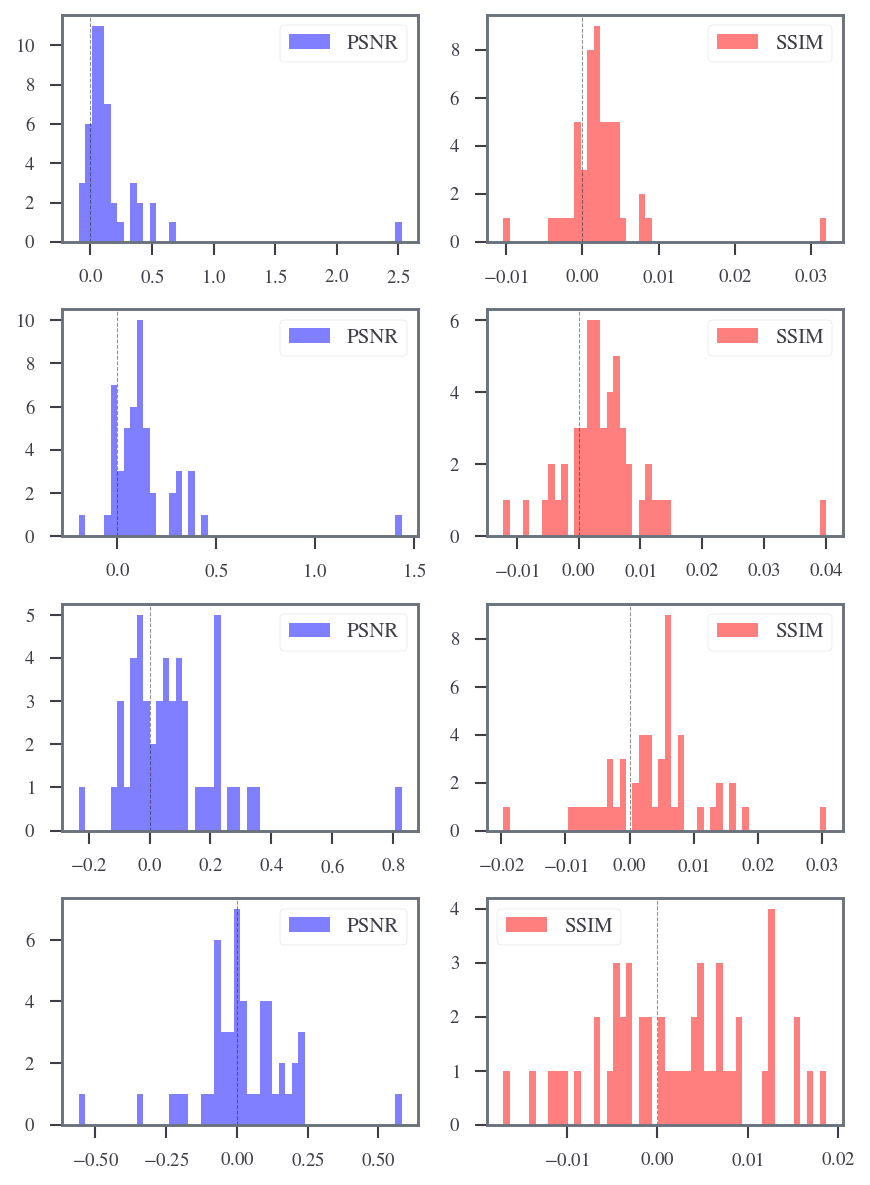

In [32]:
print("U-TGV type-2 vs U-TV, Standard50 dataset")
visualize_hist(
    [0.05, 0.1, 0.15, 0.2],
    df_A = u_tgv_type_2_standard50_df,
    df_B = u_tv_standard50_df,
    ratio=2)
plt.show()